![](title_slide.png)

# Lecture 1: Running Circuits and Interpreting Outputs
### James R. Wootton, IBM Quantum

## Memory experiments

* Quantum error correction circuits are full of measurements, designed to give us clues about the errors that occur.
* In fault-tolerant quantum computation, these results emerge while we run our algorithms. We need to process and feed insights back into the algorithm in order to correct the effects of errors.
* Currently and in the near-term, we instead run memory experiments. These end with a readout of the logical qubit, for which errors can be fixed in post-processing.
* In these lectures, we'll specifically be looking at topics as they apply to memory experiments.

## Repetiton codes with Qiskit

* Let's start with the simplest form of quantum error correction: the repetition code.
* For background on this, see [my lecture on repetition codes](https://tube.switch.ch/videos/6mPwGgSR9b).
* Though it stores a logical *bit* rather than a logical *qubit*, it uses all the methodology of quantum error correction.
* To make repetition codes with Qiskit, we'll use `QuantumCircuit`, `QuantumRegister` and `ClassicalRegister` objects.
* For an intro to qiskit see the sections [Python and Jupyter Notebooks](https://qiskit.org/textbook/ch-prerequisites/python-and-jupyter-notebooks.html) and [Qiskit](https://qiskit.org/textbook/ch-appendix/qiskit.html) from the Qiskit textbook, and/or [my lecture on using Qiskit](https://tube.switch.ch/videos/DEOosuJsiA).

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

We'll need to decide how big we want the code to be. Specifcially:
* the number of repetitions `d`;
* the number of syndrome measurement rounds `T`.

To be able to see the circuits easily, we'll start with the minimum value for `d`

In [2]:
d = 3

Let's also increase the value of `T` as we add measurement rounds to the circuit. So since we start with none...

In [3]:
T = 0

We start with an empty circuit

In [4]:
qc = QuantumCircuit()

So if we draw it, we see nothing.

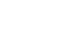

In [5]:
qc.draw(output='mpl')

then we add `d` code qubits

In [6]:
code_qubit = QuantumRegister(d, 'code_qubit')
qc.add_register( code_qubit )

and `d-1` auxilliary qubits.

In [7]:
link_qubit = QuantumRegister(d-1, 'link_qubit')
qc.add_register( link_qubit )

Then what we have is a `d=3`, `T=0` code for an encoded logical `0`. Which is still basically an empty circuit, but there are qubits with names waiting for something to happen.

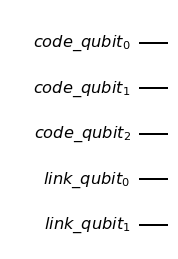

In [8]:
qc.draw(output='mpl')

Now we can add the `cx` gates required for each syndrome measurement round. Each time this cell is run, it iterates `T` by 1.

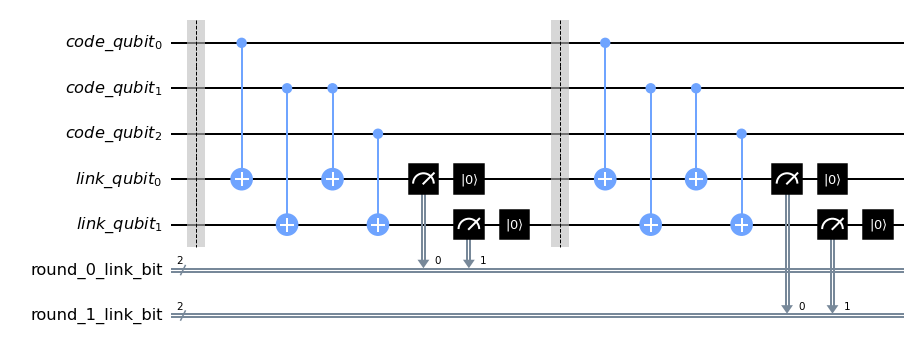

In [12]:
qc.barrier()

# for each link qubit, add a cx for the code qubit on one side
for j in range(d-1):
    qc.cx(code_qubit[j],link_qubit[j])
        
# and then one for the other side
for j in range(d-1):
    qc.cx(code_qubit[j+1],link_qubit[j])
    
# add a classical register to hold results from this round
link_bit = ClassicalRegister(d-1, 'round_'+str(T)+'_link_bit')
qc.add_register(link_bit)

# measure and then rest each link qubit to extract the syndrome
for j in range(d-1):
    qc.measure(link_qubit[j],link_bit[j])
    qc.reset(link_qubit[j])
        
# iterate the number of rounds
T += 1
    
qc.draw(output='mpl') # uncomment to draw circuit

This looks a bit nicer if we reorder the qubits.

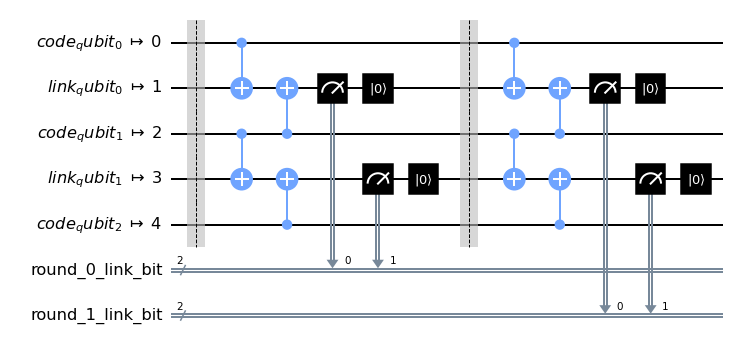

In [13]:
from qiskit import transpile

transpile(qc,initial_layout=[0,2,4,1,3]).draw(output='mpl')

So now we have a non-zero number of rounds.

In [14]:
T

2

You can run the cell that adds the syndrome measurements again to get another round.

Then we add the final readout of the code qubits.

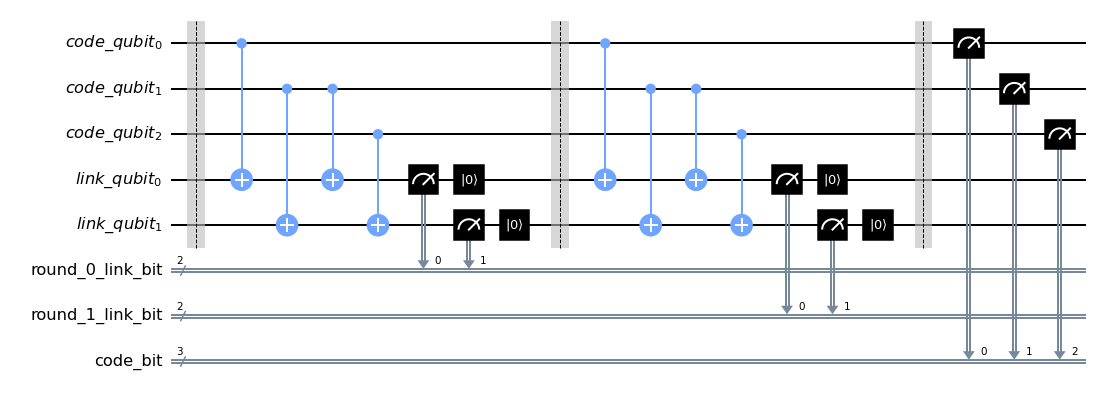

In [15]:
qc.barrier()

# add d bits for final readout of code qubits
code_bit = ClassicalRegister(d, 'code_bit')
qc.add_register(code_bit)

# measure code qubits
for j in range(d):
    qc.measure(code_qubit[j],code_bit[j])
    
qc.draw(output='mpl') # uncomment to draw circuit

Now we have a circuit, we need a backend to run it on. We'll start with just a simulator.

First we get the backend object for the simulator.

In [16]:
from qiskit import Aer

backend_sim = Aer.get_backend('aer_simulator')

Then we use this to start the process of running the circuit, by creating the job object.

In [17]:
shots = 1000
job = backend_sim.run(qc, shots=shots)

Once the job has run, we extract the result object from this.

In [18]:
result = job.result()

From this we can get our actual result: a histogram respresented as a Python dictionary.

In [19]:
counts = result.get_counts()
counts

{'000 00 00': 1000}

Since there are no errors, here we are just getting the noiseless result (`'000 00 00'` for `d=3`, `T=2`) for all of the shots. 

To see what happens when errors occur, let's manually insert some. Here are some circuits I made earlier.

In [20]:
examples_qasm = ['OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nx code_qubit[0];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nx code_qubit[0];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nx code_qubit[0];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nx code_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nx code_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nx code_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\nx code_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nx link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nx link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n','OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nx code_qubit[2];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n']

examples = []
for qasm in examples_qasm:
    examples.append(QuantumCircuit.from_qasm_str(qasm))

The errors in these examples are the following.

In [21]:
example_explanations = {
    0: "Initialization error on `code_qubit[0]`",
    1: "Error on `code_qubit[0]` while idle during first round of measurements.",
    2: "Error on `code_qubit[0]` while idle during second round of measurements.",
    3: "Initialization error on `code_qubit[1]`",
    4: "Error on `code_qubit[1]` while idle during first round of measurements.",
    5: "Error on `code_qubit[1]` while idle during second round of measurements.",
    6: "Error on `code_qubit[1]` between `cx` gates of first syndrome measurement.",
    7: "Measurement error on `link_qubit[1]` during first round of measurements.",
    8: "Measurement error on `link_qubit[1]` during second round of measurements. ",
    9: "Initialization error on `code_qubit[2]`",
}

We can now look at each of these by putting in the relevant number below. Let's start with example 3.

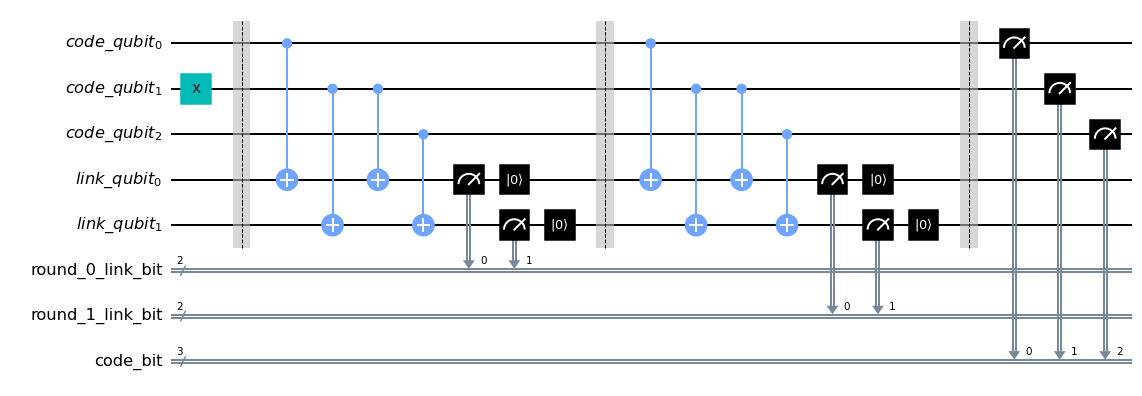

In [22]:
example = examples[3]
example.draw(output='mpl')

and the effect that it has

In [23]:
job = backend_sim.run(example, shots=shots)
counts = job.result().get_counts()
print(counts)

{'010 11 11': 1000}


The bit string here tells us the outcomes of all the bits in the circuit. To know which bits in the above output correspond to which bits in the circuit, we can looking at the list of bits below. The output bits (from left to right) correspond to the order in this list (from top to bottom). The spaces are found between bits of different classical registers.

In [24]:
example.clbits

[Clbit(ClassicalRegister(2, 'round_0_link_bit'), 0),
 Clbit(ClassicalRegister(2, 'round_0_link_bit'), 1),
 Clbit(ClassicalRegister(2, 'round_1_link_bit'), 0),
 Clbit(ClassicalRegister(2, 'round_1_link_bit'), 1),
 Clbit(ClassicalRegister(3, 'code_bit'), 0),
 Clbit(ClassicalRegister(3, 'code_bit'), 1),
 Clbit(ClassicalRegister(3, 'code_bit'), 2)]

To understand what's going on here, let's consider what all of the parts of the results mean. The output string consists of:
* On the left, a `d`-bit string of the final code qubit readouts;
* On the right, `T` lots of `d-1`-bit strings of the syndrome measurement readouts (with the rightmost being the first).

The final code qubit readouts tell us two important things:
* A final syndrome measuremement (inferred from comparing bit values);
* The value of the logical bit.

It therefore makes sense to process the result a bit to separate out these aspects.

In [25]:
def process_1(output):
    
    # split the final readouts from the syndrome measurements
    output = output.split(' ')
    
    # construct the raw logical bit readout
    logical = output[0][0]+' '+output[0][-1]

    # use the final readouts to calculate a final effective syndrome measurement
    final = ''
    for j in range(d-1):
        if output[0][j]==output[0][j+1]:
            final += '0'
        else:
            final += '1'
    output[0] = final     
    
    # put it all back together into a string
    output = logical + '  ' + ' '.join(output)
    
    return output

output = list(counts.keys())[0]
process_1(output)

'0 0  11 11 11'

Here the processed output again has two parts:
* On the left, two opinions on what the logical bit value is (taken from the code qubits at each end of the code);
* On the right `T+1` lots of `d-1`-bit strings of the syndrome measurement readouts (including the inferred one from the final readout.

If you are wondering why we take two opinions on the logical readout: it's because it will make things nice later.

It is not actually the syndrome values themselves that are useful, but it is their changes. So there's some more processing we can do, to output the syndrome changes instead of the values themselves.

In [26]:
def process_2(output):
    
    output = output.split('  ')
    logical = output[0]
    syndrome = output[1].split(' ') [::-1]  
    
    changes = [syndrome[0]]
    for t in range(T):
        change = ''
        for j in range(d-1):
            if syndrome[t][j]==syndrome[t+1][j]:
                change += '0'
            else:
                change += '1'
        changes.append(change)
    
    output = logical + '  ' + ' '.join(changes[::-1])
    
    return output

process_2(process_1(output))

'0 0  00 00 11'

So what can we do with this processed result?

* The ideal, error-free result here (for a `d=3`, `T=2` code with a stored `0`) is `0 0  00 00 00`.
* The result you see above differs from this in two places: two of the `0`s are instead `1`s.
* All the examples similarly have this final processed output flipped in two places.
* It will also be true for any single qubit Pauli error inserted anywhere in a repetition code of any size and for any number of syndrome measurement rounds.
* So by doing this processing, we distill the whole result down into a pair of hints for each error.

For large codes and large numbers of rounds, these large strings will get unwieldly. It is therefore easier to just describe which of the bits have been flipped. This is done by the following function. Given any output string of this form, it returns a list of dictionaries that contain a discription of each hint.

In [27]:
def string2nodes(string, logical='0'):

    nodes = []
    string = [substring.split(' ') for substring in string.split('  ')]

    # for hints seen in the syndrome measurement rouunds
    for t,syn in enumerate(string[1][::-1]):
        for j,s in enumerate(syn):
            if s=='1':
                # label with where and when
                node = {'element':j, 'time':t}
                nodes.append(node)
    
    # for hints seen when the logical value is incorrect
    for j,log in enumerate(string[0]):
        if log!=logical:
            # label with where
            node = {'element':j}
            # and also note that it is one seen from the logical value
            node['is_boundary']  = True
            nodes.append(node)

    return nodes

string2nodes(process_2(process_1(output)))

[{'element': 0, 'time': 0}, {'element': 1, 'time': 0}]

Now let's take a look at all the examples, from 0 to 8.

First choose the example (and see the circuit).

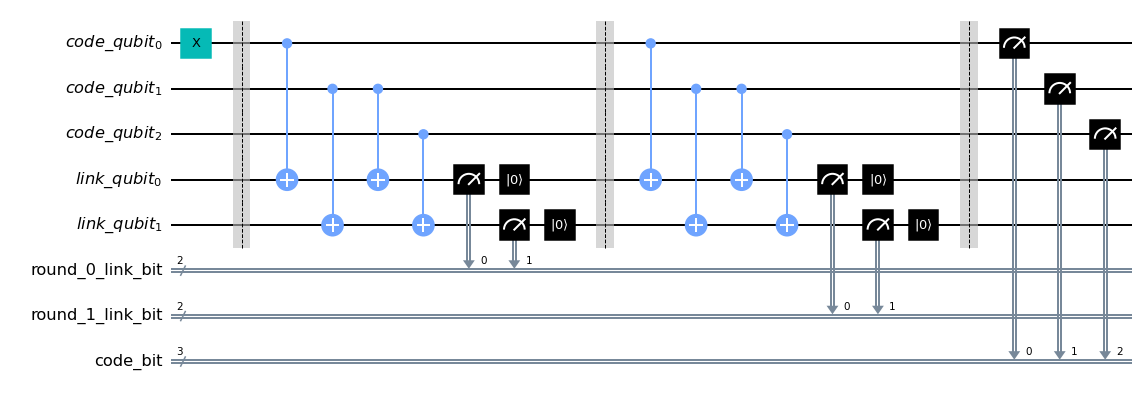

In [28]:
e = 0

example = examples[e]
example.draw(output='mpl')

Then we can run it to get the raw result.

In [29]:
job = backend_sim.run(example)
counts = job.result().get_counts()

output = list(counts.keys())[0]
output

'001 01 01'

Then process it for the processed result.

In [30]:
job = backend_sim.run(example)
counts = job.result().get_counts()

output = list(counts.keys())[0]
process_2(process_1(output))

'0 1  00 00 01'

And then turn that into a list of descriptions.

In [31]:
for node in string2nodes(process_2(process_1(output))):
    print(node)

{'element': 1, 'time': 0}
{'element': 1, 'is_boundary': True}


## Repetition Codes with qiskit-qec

* We don't usually need to create QEC circuits manually.
* Qiskit-QEC gives us tools to create repetition code circuits automatically.
* See [the install guide](https://github.com/qiskit-community/qiskit-qec/blob/main/docs/installation.md) for Qiskit-QEC.

In [32]:
from qiskit_qec.circuits import RepetitionCodeCircuit

We can create a repetition code object using

In [33]:
d = 3
T = 2

code = RepetitionCodeCircuit(d,T,resets=True,xbasis=False,barriers=True)

Here we have a few options, beyond `d` and `T`:
* `resets` determines whether a reset gate is placed after measurements;
* With `xbasis` we can choose to use the phase-flip encoding, instead of the standard bit-flip encoding.
* With `barriers` we can choose to put barriers between various parts of the circuit: useful visually and for compilation.

For the `code` object we just created, `code.circuit['0']` contains the circuit for a stored logical `0`. This is just like the one we created above.

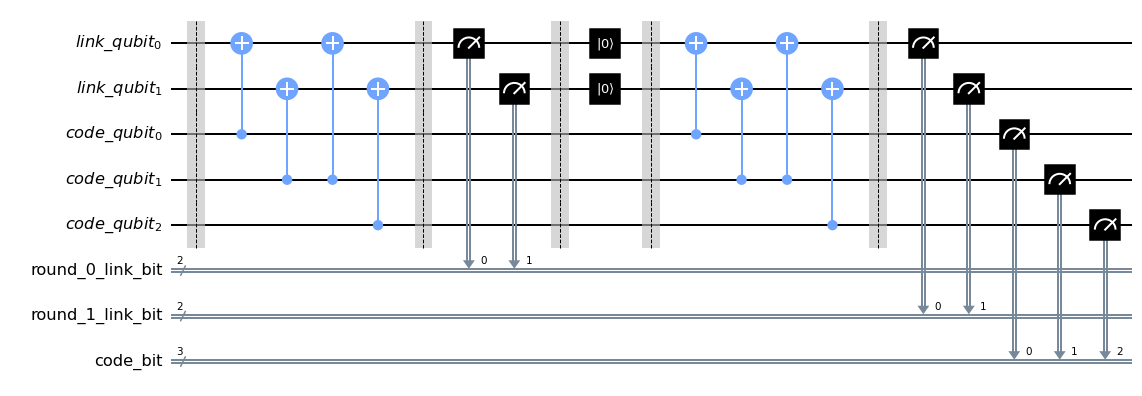

In [34]:
code.circuit['0'].draw(output='mpl')

There's also one for a stored logical `1`.

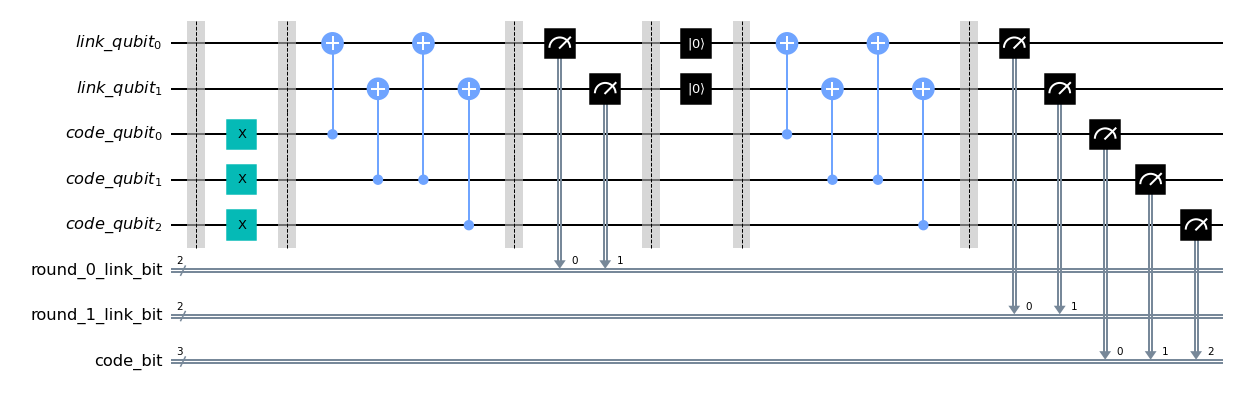

In [35]:
code.circuit['1'].draw(output='mpl')

Let's combine these into a list and run them in the same job

In [36]:
job = backend_sim.run([code.circuit['0'], code.circuit['1']], shots=shots)

and then put the results together in the same dictionary

In [37]:
raw_results = {'0':job.result().get_counts(code.circuit['0']), '1':job.result().get_counts(code.circuit['1'])}
raw_results

{'0': {'000 00 00': 1000}, '1': {'111 00 00': 1000}}

Since there are no errors, the results aren't very interesting. Just the standard code qubit readout on the left (all reflecting the logical value), and syndrome values on the right (detecting no errors).

The code object allows us to process the results in the manner discussed earlier. So the error free string corresponds to no nodes.

In [38]:
code.string2nodes('000 00 00')

[]

One with a spurious result somewhere (probably due to a measurement error) generates a pair.

In [39]:
code.string2nodes('000 01 00')

[{'time': 1, 'qubits': [1, 2], 'is_boundary': False, 'element': 1},
 {'time': 2, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}]

The same for the error free result for a logical `1` (though we need to flag up that it's a logical `1`).

In [40]:
code.string2nodes('111 00 00', logical='1')

[]

And the same spurious result from before generates the same two nodes.

In [41]:
code.string2nodes('111 01 00', logical='1')

[{'time': 1, 'qubits': [1, 2], 'is_boundary': False, 'element': 1},
 {'time': 2, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}]

## From nodes to syndrome graphs

Let's go back and run all the example circuits again.

In [42]:
job = backend_sim.run(examples)

output_list = []
node_list = []
for example in examples:
    counts = job.result().get_counts(example)
    output = list(counts.keys())[0]
    
    output_list.append( output )
    node_list.append( code.string2nodes(output) )

To construct a list of the outputs

In [43]:
output_list

['001 01 01',
 '001 01 00',
 '001 00 00',
 '010 11 11',
 '010 11 00',
 '010 00 00',
 '010 11 01',
 '000 00 10',
 '000 10 00',
 '100 10 10']

And the corresponding pairs of nodes

In [44]:
node_list

[[{'time': 0, 'qubits': [2], 'is_boundary': True, 'element': 1},
  {'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}],
 [{'time': 0, 'qubits': [2], 'is_boundary': True, 'element': 1},
  {'time': 1, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}],
 [{'time': 0, 'qubits': [2], 'is_boundary': True, 'element': 1},
  {'time': 2, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}],
 [{'time': 0, 'qubits': [0, 1], 'is_boundary': False, 'element': 0},
  {'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}],
 [{'time': 1, 'qubits': [0, 1], 'is_boundary': False, 'element': 0},
  {'time': 1, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}],
 [{'time': 2, 'qubits': [0, 1], 'is_boundary': False, 'element': 0},
  {'time': 2, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}],
 [{'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1},
  {'time': 1, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}],
 [{'time': 0, 'qubits': [0, 1], 'is_bou

We call these nodes because we will use them as nodes in a graph (a collection of nodes connected by edges). Specifically, an edge will connect pairs of nodes that are created by the same single error.

For this we'll need some graph theory tools.

In [45]:
import retworkx as rx
from retworkx.visualization import mpl_draw

Now we construct the graph:
* Each node will be labelled in the graph by an index (the `j`s and `k`s below);
* Each edge is labelled by `e`, the index of the example error it corresponds to.

In [46]:
S = rx.PyGraph()

for e,(n0,n1) in enumerate(node_list):
    
    if n0 not in S.nodes():
        j = S.add_node(n0)
    else:
        j = S.nodes().index(n0)
        
    if n1 not in S.nodes():
        k = S.add_node(n1)
    else:
        k = S.nodes().index(n1)
    
    S.add_edge(j, k, str(e))

Let's take a look at it (note that the exact layout of this will randomly change every time).

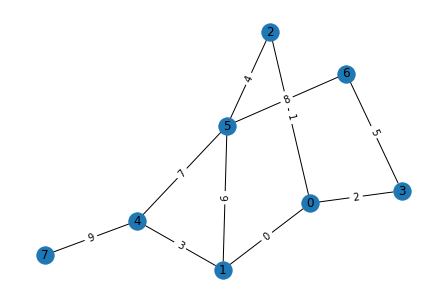

In [47]:
mpl_draw(S, with_labels=True, edge_labels=lambda edge: edge) 

## From syndrome graphs to errors

We can use this graph to deduce the likely set of errors that occurred for a given output of the circuit.

For example, suppose we get the outcome `'001 01 01'`. This corresponds to the nodes

In [48]:
nodes = code.string2nodes('001 01 01')
print(nodes)

[{'time': 0, 'qubits': [2], 'is_boundary': True, 'element': 1}, {'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}]


Which in this graph corresponds to the nodes labelled with the following indices.

In [49]:
[S.nodes().index(n) for n in nodes]

[0, 1]

We see that these nodes (0 and 1) are connected by edge 0. This gives us our most likely culprit: our first example error.

In [50]:
example_explanations[0]

'Initialization error on `code_qubit[0]`'

Now suppose the output is instead `'101 11 11'`.

In [51]:
nodes = code.string2nodes('101 11 11')
print(nodes)

[{'time': 0, 'qubits': [0], 'is_boundary': True, 'element': 0}, {'time': 0, 'qubits': [2], 'is_boundary': True, 'element': 1}, {'time': 0, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}, {'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}]


Here we see that something more complex must have happened, since there are four nodes here. So not just a single error. Their indices are as follows.

In [52]:
[S.nodes().index(n) for n in nodes]

[7, 0, 4, 1]

Among these are 0 and 1, which as we already known can be explained by error 0. This leaves 4 and 7, which the graph tells us are connected by edge 9. This can therefore be explained by our last example error.

In [53]:
example_explanations[9]

'Initialization error on `code_qubit[2]`'

Now let's consider the string `'010 01 00'`.

In [54]:
nodes = code.string2nodes('010 01 00')

[S.nodes().index(n) for n in nodes]

[2, 6]

This gives us two nodes, 2 and 6, that are not connected on our graph. This could just be because our graph is only constructed from a limited set of examples. However, like above, it could also be because more than one error occurred.

For example, errors 4 and 8 give the following outputs.

In [55]:
print(output_list[4])
print(output_list[8])

010 11 00
000 10 00


The bitwise addition of these would lead to the very string we are currently considering: `'010 01 00'`. Hence the coincidence of these two this output errors would lead to this output. On the graph we see this by the fact that nodes 2 and 6 are connected by the combination of edges 4 and 8.

In all the examples so far, our method has been the same:
* Look at what nodes are present in our output;
* Find a set of edges that form paths, with endpoints on the nodes;
* These edges correspond to a set of errors that could cause the given output.

So far we've looked at the graph created from our 9 example errors. Really we should be more systematic, running an analysis of all the different ways that a Pauli error could be inserted into the circuit, and the effects on the output that these will have. Qiskit-QEC does this for us when we initialize a `DecodingGraph` object with our code.

In [56]:
from qiskit_qec.decoders import DecodingGraph

dg = DecodingGraph(code)

Here's the full decoding graph for our code. Note that it has just as many nodes as the one we've just been considering, but many more edges. It seems there are 16 distinct ways a single Pauli error can affect this code, rather than just our nine examples.

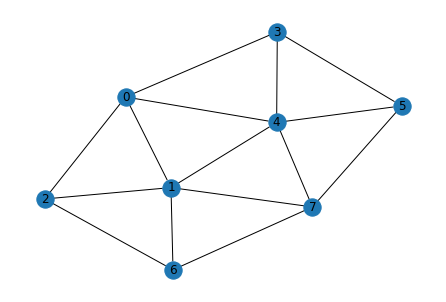

In [57]:
mpl_draw(dg.graph, with_labels=True)

Here's the data for all the edges of this graph, and the nodes they connect.

In [58]:
S = dg.graph

for n0,n1 in S.edge_list():
    print('\nEdge:', S.get_edge_data(n0,n1))
    print('Connects nodes:')
    print(S.nodes()[n0])
    print(S.nodes()[n1])


Edge: {'qubits': [], 'weight': 1}
Connects nodes:
{'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}
{'time': 1, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}

Edge: {'qubits': [2], 'weight': 1}
Connects nodes:
{'time': 0, 'qubits': [2], 'is_boundary': True, 'element': 1}
{'time': 1, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}

Edge: {'qubits': [2], 'weight': 1}
Connects nodes:
{'time': 0, 'qubits': [2], 'is_boundary': True, 'element': 1}
{'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}

Edge: {'qubits': [], 'weight': 1}
Connects nodes:
{'time': 0, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}
{'time': 1, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}

Edge: {'qubits': [1], 'weight': 1}
Connects nodes:
{'time': 0, 'qubits': [1, 2], 'is_boundary': False, 'element': 1}
{'time': 1, 'qubits': [0, 1], 'is_boundary': False, 'element': 0}

Edge: {'qubits': [1], 'weight': 1}
Connects nodes:
{'time': 0, 'qubits': [0, 1], 'is_boun

Note that the edges are described by:
* The qubits affected by the error that created them;
* A 'weight' (which we can update to include information on probability, etc).

# Conclusions

Here we started with the raw outputs of circuits, and then turned these into graphs. Using graphs like these we can process and understand the effects of errors at a more abstract level. Already we've started to do some decoding with these graphs.

Next time we'll get even more famililar with how we use these graphs for decoding.